In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install contractions
!pip install transformers
!gdown --id 1iOU9hLiRxRU6Kg7lyHzQ2og7slWZPyNc #utils
!gdown --id 1qxUViBIC9xQD39eGgKi8WWi7SzmFqlKH #network
!gdown --id 1T4qiubSRvHkVLgRbNhpvRCLXsZ3o4Ncf #dataset
!gdown --id 1yVfLxAPubn-b4ZWnKX9-lvnXT6OzmGCt #text free images
!gdown --id 1cQnxpWJwSUitkzX5mOiNpuF33poY2mR- #Annotation File

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14840 sha256=079862328948cd4b7a75d942c97a457decd2819b05a87dff888318953d21b1d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-yggcuoii/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 46.6 MB/s 
     |████████████████████████████████| 287 kB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████

In [2]:
#Load model
from google.colab import drive
import shutil
def save_model(model):
  #Saving the best model to drive
  drive.mount('/content/drive')
  shutil.copy("/content/" + model, "/content/drive/MyDrive/Dl thesis/model")
  print("Model Saved")
  drive.flush_and_unmount()

def load_model(model):
  drive.mount('/content/drive')
  shutil.copy("/content/drive/MyDrive/Dl thesis/model/" + model, '/content/')
  print("Model Loaded")
  drive.flush_and_unmount()

In [3]:
!ls
!unzip annotation_file.zip
!unzip text_free_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: text_free_images/memes_1615.png  
  inflating: __MACOSX/text_free_images/._memes_1615.png  
  inflating: text_free_images/covid_memes_3086.png  
  inflating: __MACOSX/text_free_images/._covid_memes_3086.png  
  inflating: text_free_images/memes_3764.png  
  inflating: __MACOSX/text_free_images/._memes_3764.png  
  inflating: text_free_images/covid_memes_3938.png  
  inflating: __MACOSX/text_free_images/._covid_memes_3938.png  
  inflating: text_free_images/memes_1173.png  
  inflating: __MACOSX/text_free_images/._memes_1173.png  
  inflating: text_free_images/memes_847.png  
  inflating: __MACOSX/text_free_images/._memes_847.png  
  inflating: text_free_images/memes_1167.png  
  inflating: __MACOSX/text_free_images/._memes_1167.png  
  inflating: text_free_images/memes_6608.png  
  inflating: __MACOSX/text_free_images/._memes_6608.png  
  inflating: text_free_images/memes_853.png  
  inflating: __MACOSX/text_free_images/._

In [4]:
!mv text_free_images Images
!ls

annotation_file        Images		      sample_data
annotation_file.zip    __MACOSX		      text_free_images.zip
dataset_distilbert.py  network_distilbert.py  utils_distilbert.py


In [5]:
import os
import torch
import numpy as np
from utils_distilbert import *
from network_distilbert import *
from dataset_distilbert import *
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

Using cuda device


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [6]:
train_df = pd.read_csv("./annotation_file/train.csv")
train_df

,Name,Text,Entity,Role
0,covid_memes_252.png,kwai\ngkwa 0964\n#nnevvy\napplause to Thais fr...,thais,hero
1,covid_memes_20.png,best candidate for\nJA\n2020\njoe biden\nKamal...,joe biden,hero
2,covid_memes_60.png,MASK\nTRUMP\nTRUMP\nDEN CE\nHelp your child fi...,donald trump,hero
3,covid_memes_493.png,BARACK OBAMA PRESENTS\nA MEDAL TO HIMSELF.\nFO...,barack obama,hero
4,covid_memes_321.png,*New Swine flu like virus with\nhuman pandemic...,china,hero
...,...,...,...,...
17523,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,biden obama meme,other
17524,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,john robinson,other
17525,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,memes,other
17526,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,joe biden,other


In [7]:
train_df['Role'] = train_df['Role'].map({'hero' : 0, 'villain' : 1, 'victim' : 2, 'other' : 3})
train_df

,Name,Text,Entity,Role
0,covid_memes_252.png,kwai\ngkwa 0964\n#nnevvy\napplause to Thais fr...,thais,0
1,covid_memes_20.png,best candidate for\nJA\n2020\njoe biden\nKamal...,joe biden,0
2,covid_memes_60.png,MASK\nTRUMP\nTRUMP\nDEN CE\nHelp your child fi...,donald trump,0
3,covid_memes_493.png,BARACK OBAMA PRESENTS\nA MEDAL TO HIMSELF.\nFO...,barack obama,0
4,covid_memes_321.png,*New Swine flu like virus with\nhuman pandemic...,china,0
...,...,...,...,...
17523,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,biden obama meme,3
17524,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,john robinson,3
17525,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,memes,3
17526,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,joe biden,3


In [8]:
labels, count = np.unique(train_df['Role'], return_counts = True)
print(labels, count)
class_weights = [sum(count)/ c for c in count ]
class_weights

[0 1 2 3] [  471  2441   903 13713]


[37.21443736730361, 7.180663662433429, 19.410852713178294, 1.278203164880041]

In [9]:
example_weights = [class_weights[e] for e in train_df['Role']]

In [11]:
len(example_weights)

17528

In [12]:
sampler = torch.utils.data.WeightedRandomSampler(example_weights, 9000)

In [13]:
len(sampler)

9000

In [14]:
roletolabel = {'hero' : 0, 'villain' : 1, 'victim' : 2, 'other' : 3}

In [15]:
import pandas as pd
metric_df_emb = pd.DataFrame(columns = ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy', 'Train Weighted F1', 'Validation Weighted F1', 'Train Macro F1', 'Validation Macro F1'])

In [16]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [17]:
train_dataset = Custom_emb(r"Images", r"./annotation_file/train.csv", transform, max_length=100,roletolabel = roletolabel)
train_loader = DataLoader(dataset=train_dataset, batch_size = 32, num_workers = 0, pin_memory=True, sampler=sampler)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

9024

In [ ]:
val_dataset = Custom_emb(r"Images", r"./annotation_file/val.csv",  transform, max_length = 100, roletolabel = roletolabel)
val_loader = DataLoader(dataset=val_dataset, batch_size = 32, num_workers = 0, shuffle=True, pin_memory=True)

In [ ]:
print(len(train_loader.dataset), len(val_loader.dataset))
print(len(train_loader), len(val_loader))

17528 2075
250 65


In [ ]:
embeddings = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
load_model(f"attention_model_latest_epoch_emb.pth")
load_model(f"final_attention_model_emb.pth")

Mounted at /content/drive
Model Loaded
Mounted at /content/drive
Model Loaded


In [ ]:
!ls -lrth

total 1.1G
drwxr-xr-x 2 root root 256K Apr 10 10:14 Images
drwxr-xr-x 2 root root 4.0K Apr 10 12:09 annotation_file
drwxr-xr-x 1 root root 4.0K Apr 19 14:23 sample_data
-rw-r--r-- 1 root root 3.4K Apr 23 16:52 utils.py
-rw-r--r-- 1 root root  12K Apr 23 16:52 network.py
-rw-r--r-- 1 root root 9.1K Apr 23 16:52 dataset.py
-rw-r--r-- 1 root root 1.1G Apr 23 16:52 text_free_images.zip
-rw-r--r-- 1 root root 707K Apr 23 16:52 annotation_file.zip
drwxr-xr-x 4 root root 4.0K Apr 23 16:53 __MACOSX
drwxr-xr-x 2 root root 4.0K Apr 23 16:53 __pycache__


<h2>Training

In [ ]:
from torch import nn
ocr_encoder = ocr_Encoder_emb(no_layers = 2, dropout = 0.2, embedding = embeddings)
entity_encoder = entity_Encoder_emb(no_layers = 2, dropout = 0.2, embedding = embeddings)
model = Model_emb(ocr_encoder, entity_encoder, no_of_classes = 4).to(device)

if(os.path.exists(f"./attention_model_latest_epoch_emb.pth")):
    model.load_state_dict(torch.load(f'./attention_model_latest_epoch_emb.pth'))
    print("Pretrained model Loaded")

Pretrained model Loaded


In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-6)

In [ ]:
from tqdm import tqdm

In [ ]:
train_error = []
val_error = []
val_f1 = []
train_f1 = []
min_val_f1 = -1*np.inf

for epoch in range(10):
    drive.mount('/content/drive')
    if(os.path.exists("/content/drive/MyDrive/Dl thesis/model/metric_emb.csv")):
      load_model("metric_emb.csv")
      metric_df_emb = pd.read_csv("metric_emb.csv")
    drive.flush_and_unmount()
    train_loss= 0 
    for (entity, text, image, role) in tqdm(train_loader):
        model.train()
        entity["input_ids"] = entity["input_ids"].to(device,dtype = torch.int32)
        entity["attention_mask"] = entity["attention_mask"].to(device,dtype = torch.int32)
        text["input_ids"] = text["input_ids"].to(device, dtype = torch.int32)
        text["attention_mask"] = text["attention_mask"].to(device, dtype = torch.int32)
        role = role.to(device = device, dtype = torch.int64)
        feature = vgg(image.to(device = device, dtype = torch.float32))
        feature = torch.flatten(feature, start_dim=2)
        feature = feature.permute(0, 2, 1)
        y_pred = model(text, entity, feature)  
        optimizer.zero_grad()       

        loss = criterion(y_pred, role)
        train_loss += loss.item()
    
        loss.backward()
        optimizer.step()
        
    # Saving State Dict
    torch.save(model.state_dict(), f'./attention_model_latest_epoch_emb.pth')  
    print("Training done for epoch : ", epoch+1)
    save_model(f"attention_model_latest_epoch_emb.pth")
    
#   Checking Validation 
    model.eval()
    val_acc = 0
    val_loss = 0
    with torch.no_grad():            
        for (entity, text, image, role) in tqdm(val_loader):
            entity["input_ids"] = entity["input_ids"].to(device,dtype = torch.int32)
            entity["attention_mask"] = entity["attention_mask"].to(device,dtype = torch.int32)
            text["input_ids"] = text["input_ids"].to(device, dtype = torch.int32)
            text["attention_mask"] = text["attention_mask"].to(device, dtype = torch.int32)
            role = role.to(device=device, dtype = torch.int64)
            feature = vgg(image.to(device = device, dtype = torch.float32))
            feature = torch.flatten(feature, start_dim=2)
            feature = feature.permute(0, 2, 1)
            y_pred = model(text, entity, feature)                 
            loss = criterion(y_pred, role)       
            val_loss += loss.item()
                
    acc_train, macro_train, weighted_train = score_embeddings(model,vgg, train_loader, device) 
    acc_val, macro_val, weighted_val = score_embeddings(model,vgg, val_loader, device)
    print(f"\nEpoch {epoch+1}")
    print(f'Training Loss: {(train_loss/len(train_loader)):4f} -----> Training Accuracy: {acc_train:.4f} %, Training F1 Score : {macro_train:.4f}')  
    print(f"Validation Loss: {(val_loss/len(val_loader)):.4f} -----> Validation Accuracy: {acc_val:.4f} %, Validation F1 Score : {macro_val:.4f}")
    train_error.append(train_loss/len(train_loader))
    val_error.append(val_loss/len(val_loader))  
    val_f1.append(macro_val)
    train_f1.append(macro_train)

    metric_df_emb = metric_df_emb.append({'Train Loss' : train_loss/len(train_loader), 'Validation Loss' : val_loss/len(val_loader), 
                              'Train Accuracy' : acc_train, 'Validation Accuracy' : acc_val,
                              'Train Weighted F1' : weighted_train, 'Validation Weighted F1' : weighted_val, 
                              'Train Macro F1' : macro_train, 'Validation Macro F1' : macro_val}, 
                ignore_index = True)
    
    metric_df_emb.to_csv("metric_emb.csv", index = False)

    save_model("metric_emb.csv")
     
    if min_val_f1 <= macro_val:
        print(f'Validation Macro f1 Increased({min_val_f1:.4f} ---> {macro_val:.4f}) \t Saving The Model')
        min_val_f1 = macro_val
        
        # Saving State Dict
        torch.save(model.state_dict(), f'./final_attention_model_emb.pth')
        save_model(f"final_attention_model_emb.pth")

    print("Epoch done : ", epoch+1)
    

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:34<00:00,  1.16it/s]


Training done for epoch :  1
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


[[1669   66   67  168]
 [ 130 1032  460  475]
 [  64  281 1452  194]
 [ 124  416  284 1118]]


100%|██████████| 65/65 [00:28<00:00,  2.26it/s]


[[ 14  22   4  14]
 [ 22 107  57 121]
 [  8  37  30  46]
 [111 429 304 749]]

Epoch 1
Training Loss: 1.737944 -----> Training Accuracy: 65.8875 %, Training F1 Score : 0.6576
Validation Loss: 4.3233 -----> Validation Accuracy: 43.3735 %, Validation F1 Score : 0.2703
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(-inf ---> 0.2703) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  1
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:35<00:00,  1.16it/s]


Training done for epoch :  2
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


[[1763   74   76   21]
 [ 141 1039  409  403]
 [  66  280 1543  126]
 [ 143  435  336 1145]]


100%|██████████| 65/65 [00:28<00:00,  2.27it/s]


[[ 15  21   5  13]
 [ 19 117  56 115]
 [  8  41  32  40]
 [129 443 289 732]]

Epoch 2
Training Loss: 1.578834 -----> Training Accuracy: 68.6250 %, Training F1 Score : 0.6825
Validation Loss: 4.4286 -----> Validation Accuracy: 43.1807 %, Validation F1 Score : 0.2749
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2703 ---> 0.2749) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  2
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Training done for epoch :  3
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:53<00:00,  2.19it/s]


[[1963   13   24    5]
 [ 164  908  442  452]
 [ 107  163 1610  106]
 [ 193  371  304 1175]]


100%|██████████| 65/65 [00:28<00:00,  2.27it/s]


[[ 16  19   6  13]
 [ 24 100  60 123]
 [  8  26  38  49]
 [150 397 289 757]]

Epoch 3
Training Loss: 1.482276 -----> Training Accuracy: 70.7000 %, Training F1 Score : 0.6939
Validation Loss: 4.3946 -----> Validation Accuracy: 43.9036 %, Validation F1 Score : 0.2769
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2749 ---> 0.2769) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  3
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Training done for epoch :  4
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


[[1882   77   47   30]
 [ 117 1158  388  324]
 [  99  394 1400   99]
 [ 144  488  200 1153]]


100%|██████████| 65/65 [00:28<00:00,  2.26it/s]


[[ 14  22   5  13]
 [ 19 129  50 109]
 [  8  36  32  45]
 [125 489 245 734]]

Epoch 4
Training Loss: 1.366418 -----> Training Accuracy: 69.9125 %, Training F1 Score : 0.6954
Validation Loss: 4.2566 -----> Validation Accuracy: 43.8072 %, Validation F1 Score : 0.2799
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2769 ---> 0.2799) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  4
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:34<00:00,  1.17it/s]


Training done for epoch :  5
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:54<00:00,  2.19it/s]


[[1883   44   80   20]
 [ 162  966  523  352]
 [  73  149 1737   48]
 [ 122  402  293 1146]]


100%|██████████| 65/65 [00:28<00:00,  2.27it/s]


[[ 15  20   5  14]
 [ 21 111  61 114]
 [  8  26  40  47]
 [130 418 304 741]]

Epoch 5
Training Loss: 1.260521 -----> Training Accuracy: 71.6500 %, Training F1 Score : 0.7057
Validation Loss: 4.3232 -----> Validation Accuracy: 43.7108 %, Validation F1 Score : 0.2812
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2799 ---> 0.2812) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  5
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Training done for epoch :  6
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


[[1897   63   86    5]
 [ 144 1046  415  384]
 [  72  200 1652   50]
 [ 139  417  267 1163]]


100%|██████████| 65/65 [00:28<00:00,  2.25it/s]


[[ 13  21   5  15]
 [ 18 112  58 119]
 [  6  26  37  52]
 [123 416 291 763]]

Epoch 6
Training Loss: 1.249285 -----> Training Accuracy: 71.9750 %, Training F1 Score : 0.7113
Validation Loss: 4.1279 -----> Validation Accuracy: 44.5783 %, Validation F1 Score : 0.2801
Mounted at /content/drive
Model Saved
Epoch done :  6
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:36<00:00,  1.16it/s]


Training done for epoch :  7
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


[[1943   17   63    6]
 [ 145 1147  407  259]
 [  86  189 1649   66]
 [ 162  400  234 1227]]


100%|██████████| 65/65 [00:28<00:00,  2.26it/s]


[[ 15  22   4  13]
 [ 23 123  49 112]
 [  9  29  32  51]
 [139 444 246 764]]

Epoch 7
Training Loss: 1.183670 -----> Training Accuracy: 74.5750 %, Training F1 Score : 0.7383
Validation Loss: 4.1883 -----> Validation Accuracy: 45.0120 %, Validation F1 Score : 0.2839
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2812 ---> 0.2839) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  7
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:34<00:00,  1.16it/s]


Training done for epoch :  8
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


[[1833   59   50   39]
 [ 122 1054  439  405]
 [  87  176 1615  108]
 [ 129  324  213 1347]]


100%|██████████| 65/65 [00:28<00:00,  2.28it/s]


[[ 11  19   5  19]
 [ 14 105  46 142]
 [  5  27  26  63]
 [103 373 234 883]]

Epoch 8
Training Loss: 1.115946 -----> Training Accuracy: 73.1125 %, Training F1 Score : 0.7256
Validation Loss: 3.7703 -----> Validation Accuracy: 49.3976 %, Validation F1 Score : 0.2862
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2839 ---> 0.2862) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  8
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:32<00:00,  1.17it/s]


Training done for epoch :  9
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


[[1751   98   60   18]
 [ 139 1230  371  280]
 [  73  293 1579   77]
 [ 169  402  229 1231]]


100%|██████████| 65/65 [00:28<00:00,  2.30it/s]


[[ 11  23   4  16]
 [ 13 120  46 128]
 [  5  28  28  60]
 [ 83 446 239 825]]

Epoch 9
Training Loss: 1.108408 -----> Training Accuracy: 72.3875 %, Training F1 Score : 0.7223
Validation Loss: 3.9684 -----> Validation Accuracy: 47.4217 %, Validation F1 Score : 0.2874
Mounted at /content/drive
Model Saved
Validation Macro f1 Increased(0.2862 ---> 0.2874) 	 Saving The Model
Mounted at /content/drive
Model Saved
Epoch done :  9
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Training done for epoch :  10
Mounted at /content/drive
Model Saved


100%|██████████| 250/250 [01:52<00:00,  2.21it/s]


[[1798  124   96   28]
 [ 109 1260  454  130]
 [  54  243 1666   11]
 [ 115  533  270 1109]]


100%|██████████| 65/65 [00:28<00:00,  2.28it/s]


[[ 11  23   4  16]
 [ 15 124  62 106]
 [  5  32  44  40]
 [ 88 485 296 724]]

Epoch 10
Training Loss: 1.044462 -----> Training Accuracy: 72.9125 %, Training F1 Score : 0.7258
Validation Loss: 4.2901 -----> Validation Accuracy: 43.5181 %, Validation F1 Score : 0.2834
Mounted at /content/drive
Model Saved
Epoch done :  10


In [ ]:
!gdown --id 1oHPCGkgn46a3i5_or1ZDUIOx6JY3AN8D # metric.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1oHPCGkgn46a3i5_or1ZDUIOx6JY3AN8D
To: /content/metric_emb.csv
100% 1.91k/1.91k [00:00<00:00, 3.57MB/s]


In [ ]:
metric = pd.read_csv("metric_emb.csv")

In [ ]:
metric

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy,Train Weighted F1,Validation Weighted F1,Train Macro F1,Validation Macro F1
0,5.099709,6.679546,45.7000,25.686747,0.451816,0.312293,0.453545,0.195546
1,3.128120,4.721913,57.3375,42.698795,0.567035,0.496539,0.567397,0.264564
2,2.328776,5.103102,62.7250,38.939759,0.625318,0.458663,0.625542,0.257400
3,1.737944,4.323311,65.8875,43.373494,0.655917,0.501188,0.657578,0.270310
4,1.578834,4.428584,68.6250,43.180723,0.680585,0.498990,0.682496,0.274924
5,1.482276,4.394590,70.7000,43.903614,0.694276,0.505287,0.693929,0.276913
6,1.366418,4.256648,69.9125,43.807229,0.696554,0.502267,0.695411,0.279907
7,1.260521,4.323194,71.6500,43.710843,0.706548,0.502916,0.705714,0.281153
8,1.249285,4.127943,71.9750,44.578313,0.712528,0.510033,0.711260,0.280077
9,1.183670,4.188330,74.5750,45.012048,0.739276,0.513969,0.738273,0.283944


In [ ]:
import matplotlib.pyplot as plt
def plot(x, y1, y2, x_label, y_label, y1_label, y2_label):
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(1, x + 1, 1), y1, marker='o', color = 'b', label = y1_label)
  plt.plot(np.arange(1, x + 1, 1), y2, marker='o', color = 'r', label = y2_label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

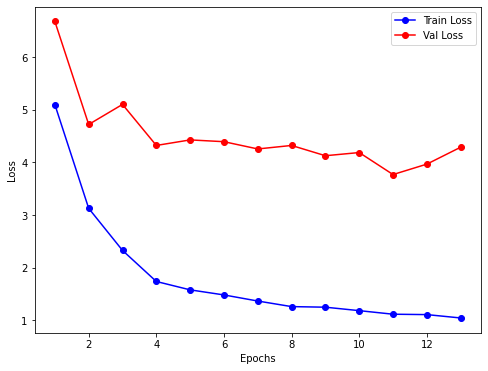

In [ ]:
plot(len(metric), metric['Train Loss'], metric['Validation Loss'], "Epochs", "Loss", "Train Loss", "Val Loss")

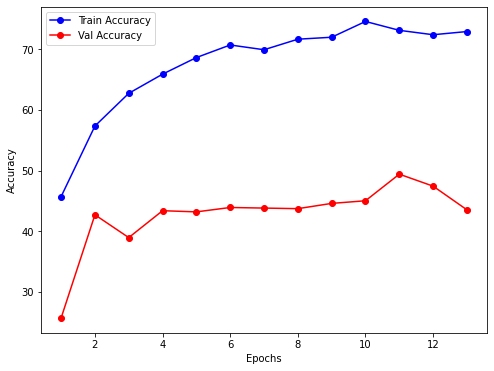

In [ ]:
plot(len(metric), metric['Train Accuracy'], metric['Validation Accuracy'], "Epochs", "Accuracy", "Train Accuracy", "Val Accuracy")

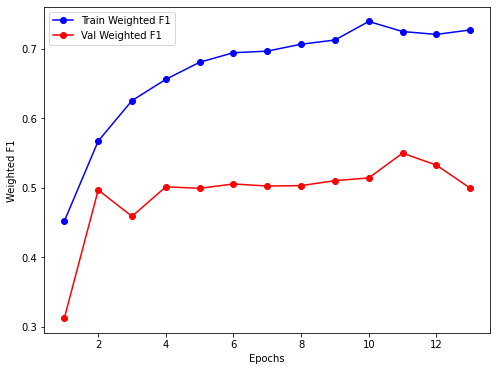

In [ ]:
plot(len(metric), metric['Train Weighted F1'], metric['Validation Weighted F1'], "Epochs", "Weighted F1", "Train Weighted F1", "Val Weighted F1")

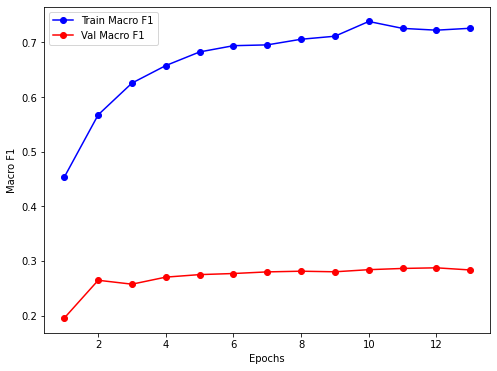

In [ ]:
plot(len(metric), metric['Train Macro F1'], metric['Validation Macro F1'], "Epochs", "Macro F1", "Train Macro F1", "Val Macro F1")

In [ ]:
import pandas as pd
results = pd.DataFrame(columns = ['Loss', 'Accuracy', 'Macro F1'], 
                   index = ['Sampled Train', 'Val','Test'])
results.loc['Sampled Train'] = [1.11, 72.38, 72.23]
results.loc['Val'] = [3.97, 47.42, 28.73]
results.loc['Test'] = [3.37, 56.03, 30.95]

results

,Loss,Accuracy,Macro F1
Sampled Train,1.11,72.38,72.23
Val,3.97,47.42,28.73
Test,3.37,56.03,30.95
